# From the paper

We attempt to reproduce and beat the results of "Sliced Wasserstein Kernels for Probability Distributions", https://openaccess.thecvf.com/content_cvpr_2016/papers/Kolouri_Sliced_Wasserstein_Kernels_CVPR_2016_paper.pdf

In [1]:
import numpy as onp
import jax.numpy as jnp
import jax
from jax.config import config

run64 = False
if run64:
    config.update("jax_enable_x64", True)
    global_type = jnp.float64
else:
    global_type = jnp.float32

In [2]:
import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

In [3]:
def get_indexes_support(n, m):
    rows = jnp.expand_dims(jnp.arange(n, dtype=jnp.float32), axis=1)
    rows = jnp.tile(rows, m) / n  # renormalize
    cols = jnp.expand_dims(jnp.arange(m, dtype=jnp.float32), axis=1)
    cols = jnp.tile(cols, n).T / m  # renormalize
    coords = jnp.stack([rows, cols], axis=-1)
    coords = jnp.reshape(coords, newshape=(n*m, 2))
    return coords

In [4]:
import tensorflow as tf
# Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], 'GPU')

In [5]:
import os

def retrieve_label(file_path):
    suffix = tf.strings.split(file_path, 'T')[-1]
    suffix = tf.strings.split(suffix, '.')[0]
    suffix = tf.strings.split(suffix, '_')
    class_label = tf.strings.to_number(suffix[0], out_type=tf.int64)
    image_index = tf.strings.to_number(suffix[1], out_type=tf.int64)
    return class_label, image_index

def process_filename(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.squeeze(img)
    class_label, image_index = retrieve_label(file_path)
    return img, class_label, image_index 

def create_texture_dataset():
    ds_images = tf.data.Dataset.list_files(
        "textures/*/*.jpg", shuffle=True
    )
    ds_images = ds_images.map(process_filename)
    return ds_images

In [6]:
import matplotlib.pyplot as plt
import itertools

def vizualize_features(features, channels='first', **kwargs):
    if channels == 'last':
        features = jnp.transpose(features, axes=[2, 3, 0, 1])
    n, m = features.shape[2], features.shape[3]
    n_row, n_col = features.shape[0], features.shape[1]
    imgs = [features[i,j] for i, j in itertools.product(range(n_row), range(n_col))]
    _, axs = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
    if n_row == 1 and n_col == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img, **kwargs)
    plt.show()

In [7]:
it_dataset = create_texture_dataset().as_numpy_iterator()

In [8]:
from skimage.feature import graycomatrix

def fill_glcm(glcm, lbda):
    eps  = 0.1 / (glcm.shape[-2]*glcm.shape[-1])
    mask = jnp.where(glcm > 0, 0., 1.)
    mask = mask / (jnp.sum(mask, axis=[-2,-1], keepdims=True) + eps)
    glcm = glcm + lbda * mask
    glcm = glcm / jnp.sum(glcm, axis=[-2,-1], keepdims=True)
    return glcm

def GLCM(img, depth=2, width=4, compression=0, lbda=0.):
    img        = onp.floor_divide(img, 1 << compression)
    distances  = onp.arange(1, depth+1)
    if width == 2:
        angles = jnp.array([0, jnp.pi / 2])
    else:
        angles = onp.linspace(0, 2*jnp.pi, num=width, endpoint=False)
    glcm       = graycomatrix(img, distances, angles,
                             levels=256 // (1 << compression),
                             normed=True, symmetric=False)
    glcm       = onp.transpose(glcm, axes=[2, 3, 0, 1])
    glcm       = jnp.array(glcm, dtype=global_type)
    if lbda > 0.:
        # force support with positive mass
        glcm = fill_glcm(glcm, lbda)
    return glcm

In [9]:
@jax.jit
def get_images_embedding(geom, glcm_features, mu, **kwargs):
    num_gray_levels = glcm_features.shape[-1]
    depth           = glcm_features.shape[0]
    width           = glcm_features.shape[1]
    g_embeddings = []
    for depth in range(glcm_features.shape[0]):
        for width in range(glcm_features.shape[1]):
            glcm = glcm_features[depth, width].ravel()
            ot_sol = sinkhorn.sinkhorn(geom, glcm, mu, **kwargs)
            g_embeddings.append(ot_sol.g)
    g_embedding = jnp.concatenate(g_embeddings, axis=0)
    return g_embedding, ot_sol

In [10]:
compression = 2
depth = 2
width = 2
num_gray_levels = 256 // (1 << compression)
lbda = 0.1  # multiplicator of smallest mass available
epsilon = 1e-3  # in Sinkhorn regularized
n, m = 480, 640
mu_type = "average"  # or mean

In [11]:
import tqdm

def compute_uniform_mu():
    uniform = jnp.ones((num_gray_levels*num_gray_levels,), dtype=global_type)
    return uniform / jnp.sum(uniform, axis=-1, keepdims=True)

def compute_average_mu():
    glcms = []
    try:
        ds = create_texture_dataset()
        pbar = tqdm.tqdm(total=int(ds.cardinality()))
        for image, label, idx in ds:
            img = image.numpy()
            glcm = GLCM(img, depth=depth, width=width, compression=compression, lbda=lbda)
            glcms.append(glcm)
            pbar.update()
    finally:
        pbar.close()
    mu = jnp.mean(jnp.stack(glcms), axis=[0,1,2])  # average over images, depths, widths
    mu = fill_glcm(mu, lbda)
    mu = mu.ravel()
    return mu

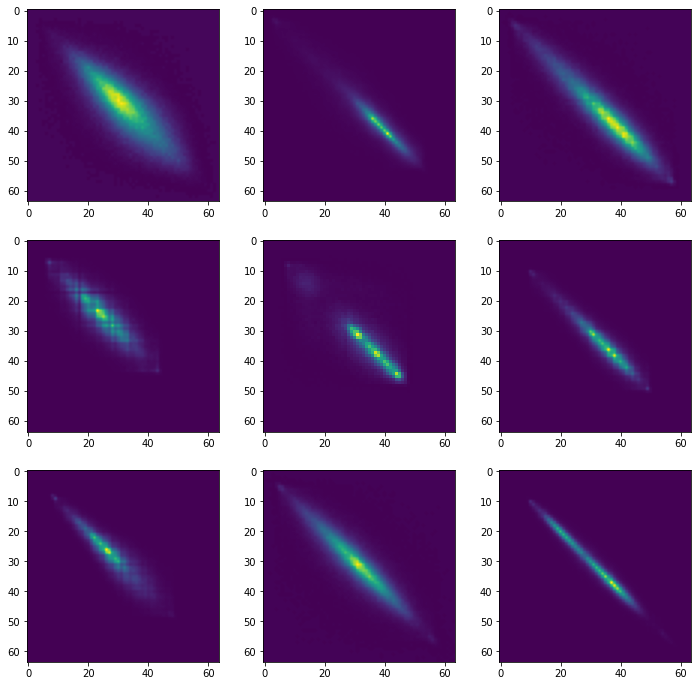

In [17]:
toy_glcms = []
for img_id in range(1, 9+1):
    file_path = f"img{img_id}.jpg"
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.squeeze(img)
    img = img.numpy()
    glcm = GLCM(img, depth=depth, width=width, compression=compression, lbda=lbda)
    glcm = glcm[0,0]
    toy_glcms.append(glcm)
toy_glcms = onp.array(toy_glcms).reshape((3,3)+glcm.shape)
vizualize_features(toy_glcms, vmin=0.)

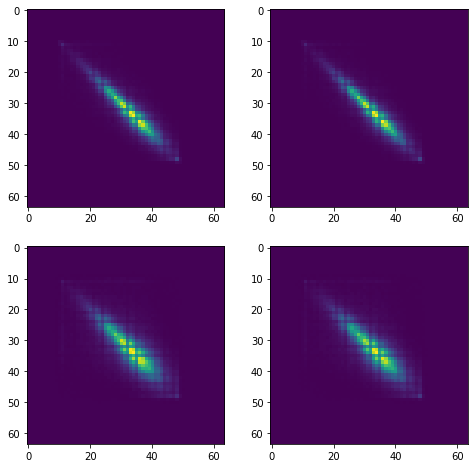

In [12]:
img = next(it_dataset)[0]
glcm = GLCM(img, depth=depth, width=width, compression=compression, lbda=lbda)
vizualize_features(glcm, vmin=0.)

100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.62it/s]


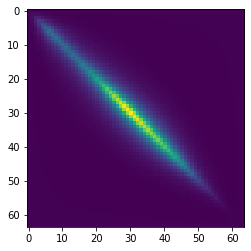

In [13]:
from ott.geometry import grid
geom = grid.Grid(grid_size=[num_gray_levels, num_gray_levels], epsilon=epsilon)
if mu_type == "uniform":
    mu = compute_uniform_mu()
elif mu_type == "average":
    mu = compute_average_mu()
vizualize_features(mu.reshape((1,1,num_gray_levels,num_gray_levels)))

errors=(DeviceArray(0.3964544, dtype=float32), DeviceArray(-1., dtype=float32)), converged=True, cost=0.0184


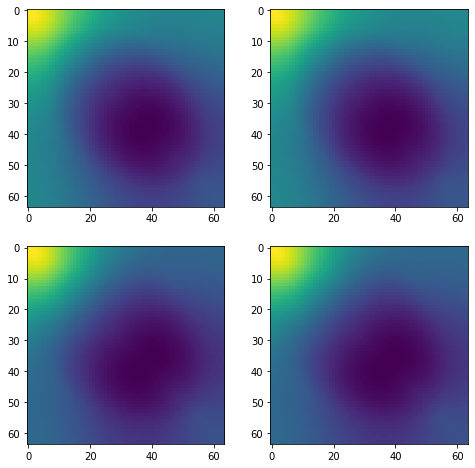

In [14]:
glcm = GLCM(img, depth=depth, width=width, compression=compression, lbda=lbda)
g_embeddings, ot_sol = get_images_embedding(geom, glcm, mu)
img_embedding = g_embeddings.reshape(glcm.shape)
print(f"errors={ot_sol.errors[0],ot_sol.errors[-1]}, converged={ot_sol.converged}, cost={ot_sol.reg_ot_cost:.4f}")
vizualize_features(img_embedding)

In [15]:
import pandas as pd
df_describe = pd.DataFrame(img_embedding.ravel())
desc = df_describe.describe().transpose()
desc

,count,mean,std,min,25%,50%,75%,max
0,16384.0,0.015743,0.044785,-0.047538,-0.016579,0.008246,0.039003,0.182614


In [17]:
import tqdm 

ds = create_texture_dataset()
features = []
raw = []
labels = []
indices = []
try:
    pbar = tqdm.tqdm(total=int(ds.cardinality()))
    converged_hist = []
    for image, label, idx in ds:
        img = image.numpy()
        glcm = GLCM(img, depth=depth, width=width, compression=compression, lbda=lbda)
        raw.append(glcm.ravel())
        g_embeddings, ot_sol = get_images_embedding(geom, jnp.array(glcm), jnp.array(mu))
        features.append(g_embeddings.reshape(glcm.shape))
        labels.append(label)
        indices.append(idx)
        converged_hist.append(ot_sol.converged)
        pbar.set_description(f"converged={jnp.mean(jnp.array(converged_hist))*100:.2f}%")
        pbar.update()
    features = jnp.stack(features).reshape((len(features), -1))
    raw = jnp.stack(raw, axis=0).reshape((len(raw), -1))
    labels = jnp.stack([label.numpy() for label in labels])
    indices = jnp.stack([idx.numpy() for idx in indices])
finally:
    pbar.close()

converged=100.00%: 100%|██████████████████████████████████████████████████████| 1000/1000 [11:35<00:00,  1.44it/s]


In [18]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'SinkhornKernelLargeScale.ipynb'
import wandb
wandb.login()

wandb: Currently logged in as: algue (use `wandb login --relogin` to force relogin)


True

In [19]:
from types import SimpleNamespace
import math
config = SimpleNamespace(
    depth=depth,
    width=width,
    compression=compression,
    num_gray_levels=num_gray_levels,
    mu_type=mu_type,
    lbda=lbda
)
wandb.init(project="sinkhorn_kernel", config=config.__dict__)
table = wandb.Table(columns=['Type', 'Best acc', 'Best params'])
print(config)

namespace(depth=2, width=2, compression=2, num_gray_levels=64, mu_type='average', lbda=0.1)


In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [21]:
svc = SVC()
grid_cv_features = GridSearchCV(svc, param_grid={'gamma':['scale','auto'], 'C':[0.1, 1, 10, 100, 1000]},
                                cv=5, scoring='accuracy',  # balanced learning so ok.
                                n_jobs=12)  # keep 4 cores for other process running in parallel
grid_cv_features = grid_cv_features.fit(features, labels)
grid_cv_features.best_score_, grid_cv_features.best_params_

(0.8720000000000001, {'C': 1000, 'gamma': 'scale'})

In [ ]:
svc = SVC(**grid_cv_features.best_params_)
svc.fit(features, labels)

In [22]:
table.add_data('features', grid_cv_features.best_score_, grid_cv_features.best_params_)

In [23]:
svc = SVC()
grid_cv_raw = GridSearchCV(svc, param_grid={'gamma':['scale','auto'], 'C':[0.1, 1, 10, 100, 1000]},
                           cv=5, scoring='accuracy',  # balanced learning so ok.
                           n_jobs=12)  # keep 4 cores for other process running in parallel
grid_cv_raw = grid_cv_raw.fit(raw.astype(jnp.float64), labels)
grid_cv_raw.best_score_, grid_cv_raw.best_params_

/home/lbethune/anaconda3/envs/dro/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(0.873, {'C': 100, 'gamma': 'scale'})

In [24]:
table.add_data('raw', grid_cv_features.best_score_, grid_cv_features.best_params_)

In [25]:
wandb.finish()

In [26]:
svc = SVC()
grid_cv_features = GridSearchCV(svc, param_grid={'gamma':['scale','auto'], 'C':[1, 10, 50, 100, 200]},
                                cv=5, scoring='accuracy',  # balanced learning so ok.
                                n_jobs=12)  # keep 4 cores for other process running in parallel
grid_cv_features = grid_cv_features.fit(onp.array(features, dtype=onp.float64), labels)
grid_cv_features.best_score_, grid_cv_features.best_params_

/home/lbethune/anaconda3/envs/dro/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(0.8719999999999999, {'C': 100, 'gamma': 'scale'})

In [27]:
svc = SVC()
grid_cv_raw = GridSearchCV(svc, param_grid={'gamma':['scale','auto'], 'C':[1, 10, 50, 100, 200]},
                           cv=5, scoring='accuracy',  # balanced learning so ok.
                           n_jobs=12)  # keep 4 cores for other process running in parallel
grid_cv_raw = grid_cv_raw.fit(onp.array(raw, dtype=onp.float64), labels)
grid_cv_raw.best_score_, grid_cv_raw.best_params_

(0.873, {'C': 100, 'gamma': 'scale'})